In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

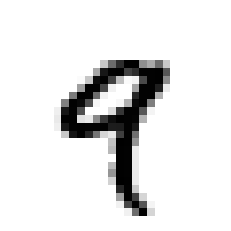

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[4]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [6]:
y[4]

'9'

In [10]:
import numpy as np
y = y.astype(np.uint8)
y[4]

9

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_9_folds = y_train_9[train_index]
    y_test_9_folds = y_train_9[test_index]
    
    clone_clf.fit(X_train_folds, y_train_9_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_9_folds)
    print(n_correct / len(y_pred))

0.94065
0.94405
0.94885


In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9456 , 0.95195, 0.9509 ])

In [31]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.8993 , 0.8999 , 0.90335])

In [32]:
all_clf = SGDClassifier(random_state=42)
all_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [33]:
all_clf.predict([some_digit])

array([9], dtype=uint8)

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [36]:
y_train_pred.shape

(60000,)

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]])

In [41]:
y_train_perfect_predictions = y_train_9
confusion_matrix(y_train_9, y_train_perfect_predictions)

array([[54051,     0],
       [    0,  5949]])

In [43]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_9, y_train_pred)

0.7610017889087657

In [45]:
recall_score(y_train_9, y_train_pred)

0.7150781643973777

In [46]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.737325591472398

In [47]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1468.75336355])

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method='decision_function')

In [49]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train_9, y_scores)

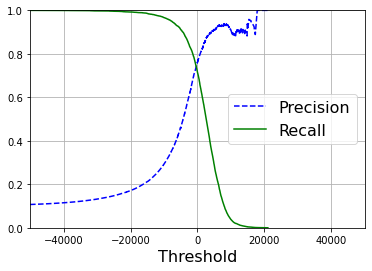

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1]) 

plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

In [52]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

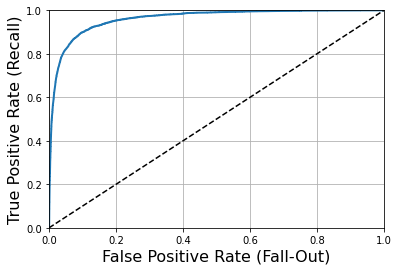

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plot_roc_curve(fpr, tpr)
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.96114559368217

In [57]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")

In [61]:
y_probas_forest.shape
y_probas_forest[:9]

array([[0.99, 0.01],
       [1.  , 0.  ],
       [0.95, 0.05],
       [1.  , 0.  ],
       [0.13, 0.87],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ]])

In [63]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

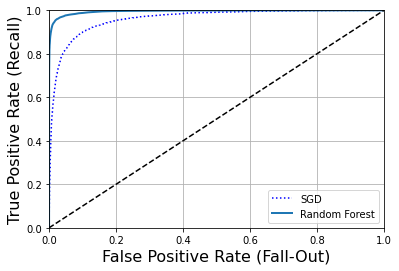

In [65]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [66]:
roc_auc_score(y_train_9, y_scores_forest)

0.9952328942154235

In [67]:
forest_clf = RandomForestClassifier(random_state=42)
y_train_9_pred = cross_val_predict(forest_clf, X_train, y_train_9, cv=3)

In [68]:
precision_score(y_train_9, y_train_9_pred)

0.9819324430479183

In [69]:
recall_score(y_train_9, y_train_9_pred)

0.8404773911581779

In [71]:
sgd_clf.classes_

array([False,  True])

In [77]:
array.shape

NameError: name 'array' is not defined